In [1]:
from pathlib import Path
import json

def load_json(path):
    with open(path) as f:
        return json.load(f)
    
def load_data_for(city_data_dir):
    return {
        p.stem : load_json(p)
        for p in Path(city_data_dir).iterdir()
        if p.is_file() and "json" in p.suffix
    }

################################################
# Replace with the path to your data directory #
################################################
data_path = "parking_geometry/ogden_ut"
data = load_data_for(data_path)

In [2]:
import shapely as sh
import numpy as np

def fix_loop(polygon_points):
    """
    some geometry libraries don't like polygons with an extra point at the end
    of the list at the same location as the start point.
    This removes such a point.
    """
    if polygon_points[0] == polygon_points[-1]:
        return polygon_points[:-1]
    else:
        return polygon_points

parking_lot_polygons = [
    sh.Polygon(fix_loop(w["coordinates"][0][:-1]))
    for w in data.values()
]

all_points = np.concatenate(
    [
        list(p.exterior.coords) for p in parking_lot_polygons
    ]
)

# lat/lon bounds for plotting
min_x, min_y = np.min(all_points, axis=0)
max_x, max_y = np.max(all_points, axis=0)

Text(0.5, 1.0, 'All parking lots (blue) in the city')

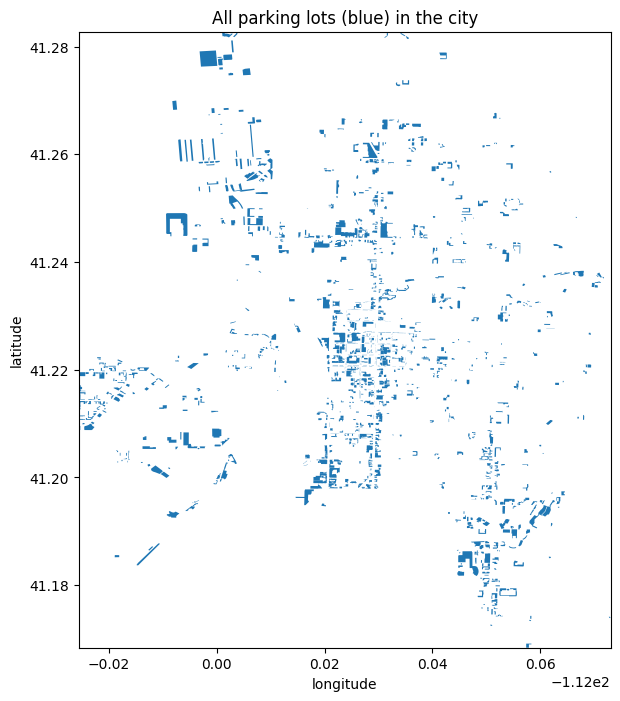

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as pch

plt.rcParams['figure.figsize'] = [8, 8]

def shapely_to_matplotlib(poly:sh.Polygon, **kwargs):
    return pch.Polygon(poly.exterior.coords, closed=True, **kwargs)

def plot_parking_spaces(ax, parking_polygons):
    for p in parking_polygons:
        ax.add_patch(shapely_to_matplotlib(p))

def new_latlon_plot():
    fig, ax = plt.subplots()
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    ax.set_aspect("equal")
    return fig, ax

fig, ax = new_latlon_plot()
plot_parking_spaces(ax, parking_lot_polygons)
ax.set_xlim([min_x, max_x])
ax.set_ylim([min_y, max_y])
ax.set_title("All parking lots (blue) in the city")

Text(0.5, 1.0, 'All parking lots (blue) in the city center (black)')

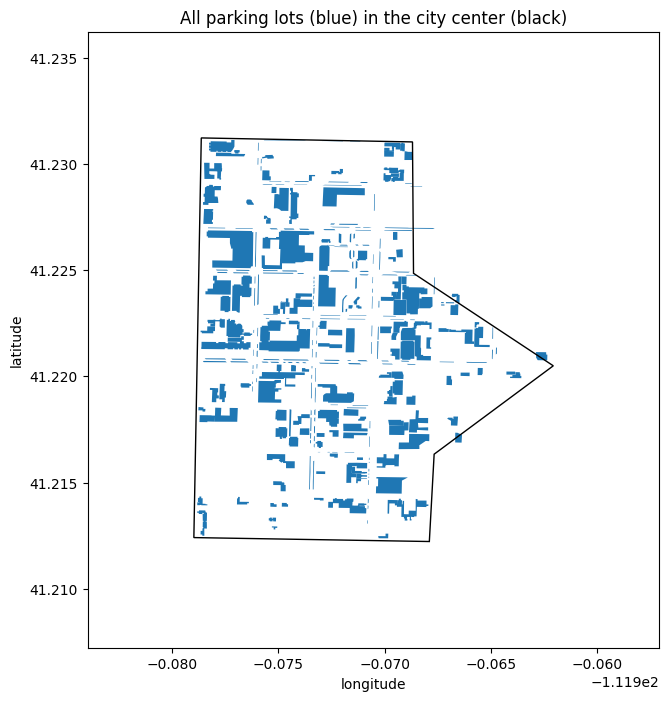

In [4]:
#################################################################
# Define your city center as a polygon with lat/lon coordinates #
#################################################################
city_center_poly_coords_latlon = np.array([
    [41.231223, -111.978633], # 20th and Wall
    [41.231035, -111.968689], # 20th and Ogden
    [41.224849, -111.968641], # 23rd and Ogden
    [41.220495, -111.962061], # 25th and Madison
    [41.216334, -111.967670], # 27th and Adams
    [41.212223, -111.967896], # 29th and Adams
    [41.212408, -111.978982], # 29th and Wall
])

# `flip` is here because typically (lon,lat) is used internally, but people are
# more familiar with (lat, lon)
city_center_poly_coords = np.flip(city_center_poly_coords_latlon, axis=1)

city_center_poly = sh.Polygon(city_center_poly_coords)
city_center_mpl = shapely_to_matplotlib(
    city_center_poly,
    facecolor="k",
    fill=False
)

overlap_filter = city_center_poly.intersects

parking_lots_in_center = list(filter(overlap_filter, parking_lot_polygons))

min_center_x, min_center_y = np.min(city_center_poly_coords, axis=0)
max_center_x, max_center_y = np.max(city_center_poly_coords, axis=0)

margin = 0.005

fig, ax = new_latlon_plot()
plot_parking_spaces(ax, parking_lots_in_center)
ax.add_patch(city_center_mpl)
ax.set_xlim([min_center_x-margin, max_center_x+margin])
ax.set_ylim([min_center_y-margin, max_center_y+margin])
ax.set_title("All parking lots (blue) in the city center (black)")

In [5]:
from pyproj import Geod

geod = Geod(ellps="WGS84")

def polygon_area(poly):
    # `abs` is needed because the area may be negative depending on the direction
    # of the polygon's points
    return abs(geod.geometry_area_perimeter(poly)[0])

city_center_area = polygon_area(city_center_poly)
parking_area = sum( polygon_area(p) for p in parking_lots_in_center )
ratio = parking_area / city_center_area

print("The city center is {:.2f} square meters".format(city_center_area))
print("Parking lots use {:.2f} square meters of that space".format(parking_area))
print("Therefore the city center is {:.2f}% parking lot".format(ratio*100))

The city center is 2091975.59 square meters
Parking lots use 411611.85 square meters of that space
Therefore the city center is 19.68% parking lot
